In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix
import os

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)
np.random.seed(42)

In [2]:
def create_windows(data, look_back=5, look_ahead=3):
    
    X, y = [], []
    for i in range(len(data) - look_back - look_ahead + 1):
        window = data[i : i + look_back]
        target = data[i + look_back + look_ahead - 1]
        X.append(window)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

def load_data(name, task):
    path_map = {
        'ECG': '../Datasets/data/dataset/regression/ECG Datasets.xlsx',
        'Lorenz': '../Datasets/data/dataset/regression/Lorenz Dataset.xlsx',
        'Wine': '../Datasets/data/dataset/classification/classification-wine.xlsx',
        'Iris': '../Datasets/data/dataset/classification/classification-iris.xlsx'
    }
    
    path = path_map.get(name)
    if not path: raise FileNotFoundError(f"Path for {name} not found")

    scaler = StandardScaler()
    
    if task == 'regression':
        try: df = pd.read_excel(path, header=None)
        except: df = pd.read_csv(path, header=None)
        
        raw = df.values.flatten().reshape(-1, 1)
        data_norm = scaler.fit_transform(raw).flatten()
        X, y = create_windows(data_norm, look_back=5, look_ahead=3)
        return X, y, None
        
    elif task == 'classification':
        df = pd.read_excel(path, header=None)
        X_raw = df.iloc[:, :-1].values
        y_raw = df.iloc[:, -1].values
        
        X = scaler.fit_transform(X_raw)
        
        le = LabelEncoder()
        y_int = le.fit_transform(y_raw)
        
        ohe = OneHotEncoder(sparse_output=False)
        y_ohe = ohe.fit_transform(y_int.reshape(-1, 1))
        y_ohe_scaled = y_ohe * 0.8 + 0.1 # Range [0.1, 0.9]
        
        return X, y_ohe_scaled, y_int

In [3]:
class Layer:
    def __init__(self, input_dim, output_dim, reg_lambda, reg_power):
        self.reg_lambda = reg_lambda
        self.reg_power = reg_power
        
        # He Initialization
        limit = np.sqrt(2.0 / input_dim)
        self.W = np.random.randn(input_dim, output_dim) * limit
        self.b = np.zeros((1, output_dim))
        
        # Flexible Alpha (Initialized to 1.0)
        self.alpha = np.ones((1, output_dim))
        
        # Adam Optimizer States
        self.mW, self.vW = np.zeros_like(self.W), np.zeros_like(self.W)
        self.mb, self.vb = np.zeros_like(self.b), np.zeros_like(self.b)
        self.ma, self.va = np.zeros_like(self.alpha), np.zeros_like(self.alpha)
        
        # Gradients
        self.dW = None
        self.db = None
        self.dalpha = None
        
        # Forward Cache
        self.input = None
        self.net = None

class RobustMLP:
    def __init__(self, layers_dims, mode='A'):
        
        self.layers = []
        self.mode = mode
        self.prev_error = 0 
        
        reg_configs = [(0.5, 2), (0.5, 2), (0.25, 3), (0.25, 2)]
        
        for i in range(len(layers_dims) - 1):
            lam, p = reg_configs[i] if i < 4 else (0, 2)
            self.layers.append(Layer(layers_dims[i], layers_dims[i+1], lam, p))
            
        # Emotional coeffs
        self.k1 = 0.9
        self.k2 = 0.1

    def activation(self, net, alpha):
        safe_alpha = np.where(np.abs(alpha) < 1e-6, 1e-6 * np.sign(alpha), alpha)
        val = (1.0 / safe_alpha) - np.tanh((safe_alpha * net) / 2.0)
        return val

    def deriv_input(self, net, alpha):
        arg = (alpha * net) / 2.0
        sech2 = 1.0 - np.tanh(arg)**2
        return -0.5 * alpha * sech2

    def deriv_alpha(self, net, alpha):
        safe_alpha = np.where(np.abs(alpha) < 1e-6, 1e-6 * np.sign(alpha), alpha)
        arg = (safe_alpha * net) / 2.0
        sech2 = 1.0 - np.tanh(arg)**2
        
        t1 = -1.0 / (safe_alpha**2)
        t2 = -0.5 * net * sech2
        return t1 + t2

    def forward(self, X):
        out = X
        for layer in self.layers:
            layer.input = out
            layer.net = np.dot(out, layer.W) + layer.b
            
            curr_alpha = layer.alpha if self.mode in ['C', 'D'] else np.ones_like(layer.alpha)
            
            out = self.activation(layer.net, curr_alpha)
        return out

    def backward(self, y_true, y_pred):
        N = y_true.shape[0]
        error = y_true - y_pred
        
        # Emotional Learning Logic
        if self.mode in ['B', 'C', 'D']:
            curr_mean = np.mean(error, axis=0)
            diff = error - self.prev_error
            emo_error = self.k1 * error + self.k2 * diff
            self.prev_error = np.mean(error, axis=0)
            d_loss = -2 * emo_error
        else:
            d_loss = -2 * error
            
        delta = d_loss
        
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            curr_alpha = layer.alpha if self.mode in ['C', 'D'] else np.ones_like(layer.alpha)
            
            d_act = self.deriv_input(layer.net, curr_alpha)
            delta_local = delta * d_act
            
            layer.dW = np.dot(layer.input.T, delta_local) / N
            
            if layer.reg_power == 2:
                reg = layer.reg_lambda * 2 * layer.W
            else:
                reg = layer.reg_lambda * 3 * (layer.W**2) * np.sign(layer.W)
            layer.dW += reg / N
            
            layer.db = np.sum(delta_local, axis=0, keepdims=True) / N
            
            if self.mode in ['C', 'D']:
                d_out_alpha = self.deriv_alpha(layer.net, layer.alpha)
                grad_alpha = delta * d_out_alpha 
                layer.dalpha = np.sum(grad_alpha, axis=0, keepdims=True) / N
                layer.dalpha = np.clip(layer.dalpha, -1.0, 1.0)
            
            delta = np.dot(delta_local, layer.W.T)
            
            layer.dW = np.clip(layer.dW, -5.0, 5.0)
            layer.db = np.clip(layer.db, -5.0, 5.0)

    def update(self, lr, t):
        beta1, beta2, eps = 0.9, 0.999, 1e-8
        
        for layer in self.layers:
            layer.mW = beta1 * layer.mW + (1-beta1) * layer.dW
            layer.vW = beta2 * layer.vW + (1-beta2) * (layer.dW**2)
            m_hat = layer.mW / (1 - beta1**(t+1))
            v_hat = layer.vW / (1 - beta2**(t+1))
            layer.W -= lr * m_hat / (np.sqrt(v_hat) + eps)
            
            layer.mb = beta1 * layer.mb + (1-beta1) * layer.db
            layer.vb = beta2 * layer.vb + (1-beta2) * (layer.db**2)
            m_hat = layer.mb / (1 - beta1**(t+1))
            v_hat = layer.vb / (1 - beta2**(t+1))
            layer.b -= lr * m_hat / (np.sqrt(v_hat) + eps)
            
            if self.mode in ['C', 'D']:
                lr_a = lr * 0.1 
                if self.mode == 'D': lr_a = lr 
                
                layer.ma = beta1 * layer.ma + (1-beta1) * layer.dalpha
                layer.va = beta2 * layer.va + (1-beta2) * (layer.dalpha**2)
                m_hat = layer.ma / (1 - beta1**(t+1))
                v_hat = layer.va / (1 - beta2**(t+1))
                layer.alpha -= lr_a * m_hat / (np.sqrt(v_hat) + eps)

    def train(self, X_train, y_train, X_test, y_test, epochs, lr):
        history = {'train': [], 'test': []}
        
        for e in range(epochs):
            
            y_p = self.forward(X_train)
            self.backward(y_train, y_p)
            self.update(lr, e)
            
            mse_tr = np.mean((y_train - y_p)**2)
            y_pt = self.forward(X_test)
            mse_ts = np.mean((y_test - y_pt)**2)
            
            history['train'].append(mse_tr)
            history['test'].append(mse_ts)
            
            if e % 50 == 0:
                print(f"Ep {e:3d} | Train: {mse_tr:.4f} | Test: {mse_ts:.4f}")
                
        return history

In [4]:
def run_experiment(dataset_name, task, scenarios):
    print(f"\n{'#'*20} {dataset_name} ({task}) {'#'*20}")
    
    X, y, y_true_labels = load_data(dataset_name, task)
    
    if task == 'classification':
        X_tr, X_ts, y_tr, y_ts, _, y_ts_lbl = train_test_split(
            X, y, y_true_labels, test_size=0.3, stratify=y_true_labels, random_state=42
        )
    else:
        X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.3, shuffle=False)
    
    input_dim = X.shape[1]
    output_dim = y.shape[1]
    dims = [input_dim, 12, 10, 8, output_dim]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    fig.suptitle(f"{dataset_name} Results", fontsize=16)
    
    for idx, (mode, desc) in enumerate(scenarios.items()):
        print(f"\n--- {desc} ---")
        model = RobustMLP(dims, mode=mode)
        
        lr = 0.01 
        epochs = 500 
        
        hist = model.train(X_tr, y_tr, X_ts, y_ts, epochs=epochs, lr=lr)
        preds = model.forward(X_ts)
        
        ax = axes[idx]
        if task == 'regression':
            ax.plot(hist['train'], label='Train')
            ax.plot(hist['test'], label='Test')
            ax.set_title(f"{desc} Loss")
            ax.legend()
        else:
            pred_lbl = np.argmax(preds, axis=1)
            acc = accuracy_score(y_ts_lbl, pred_lbl)
            print(f"Final Acc: {acc*100:.2f}%")
            
            cm = confusion_matrix(y_ts_lbl, pred_lbl)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f"{desc} (Acc: {acc*100:.1f}%)")
            
    suffix = "loss" if task == 'regression' else "cm"
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"{dataset_name}_{suffix}.png")
    plt.show()


#################### ECG (regression) ####################

--- Normal ---
Ep   0 | Train: 4.8681 | Test: 4.7796
Ep  50 | Train: 0.9524 | Test: 1.1277
Ep 100 | Train: 0.9382 | Test: 1.1151
Ep 150 | Train: 0.8957 | Test: 1.0613
Ep 200 | Train: 0.7637 | Test: 0.8928
Ep 250 | Train: 0.7494 | Test: 0.8795
Ep 300 | Train: 0.7458 | Test: 0.8753
Ep 350 | Train: 0.7435 | Test: 0.8729
Ep 400 | Train: 0.7416 | Test: 0.8709
Ep 450 | Train: 0.7397 | Test: 0.8689

--- Emotional ---
Ep   0 | Train: 4.3146 | Test: 4.0984
Ep  50 | Train: 0.9341 | Test: 1.1068
Ep 100 | Train: 0.8064 | Test: 0.9436
Ep 150 | Train: 0.7650 | Test: 0.8962
Ep 200 | Train: 0.7554 | Test: 0.8857
Ep 250 | Train: 0.7496 | Test: 0.8792
Ep 300 | Train: 0.7453 | Test: 0.8747
Ep 350 | Train: 0.7426 | Test: 0.8719
Ep 400 | Train: 0.7410 | Test: 0.8703
Ep 450 | Train: 0.7399 | Test: 0.8693

--- Emotional+Flexible ---
Ep   0 | Train: 1.2476 | Test: 1.3146
Ep  50 | Train: 0.8713 | Test: 1.0312
Ep 100 | Train: 0.7129 | Test: 0.8415
Ep 

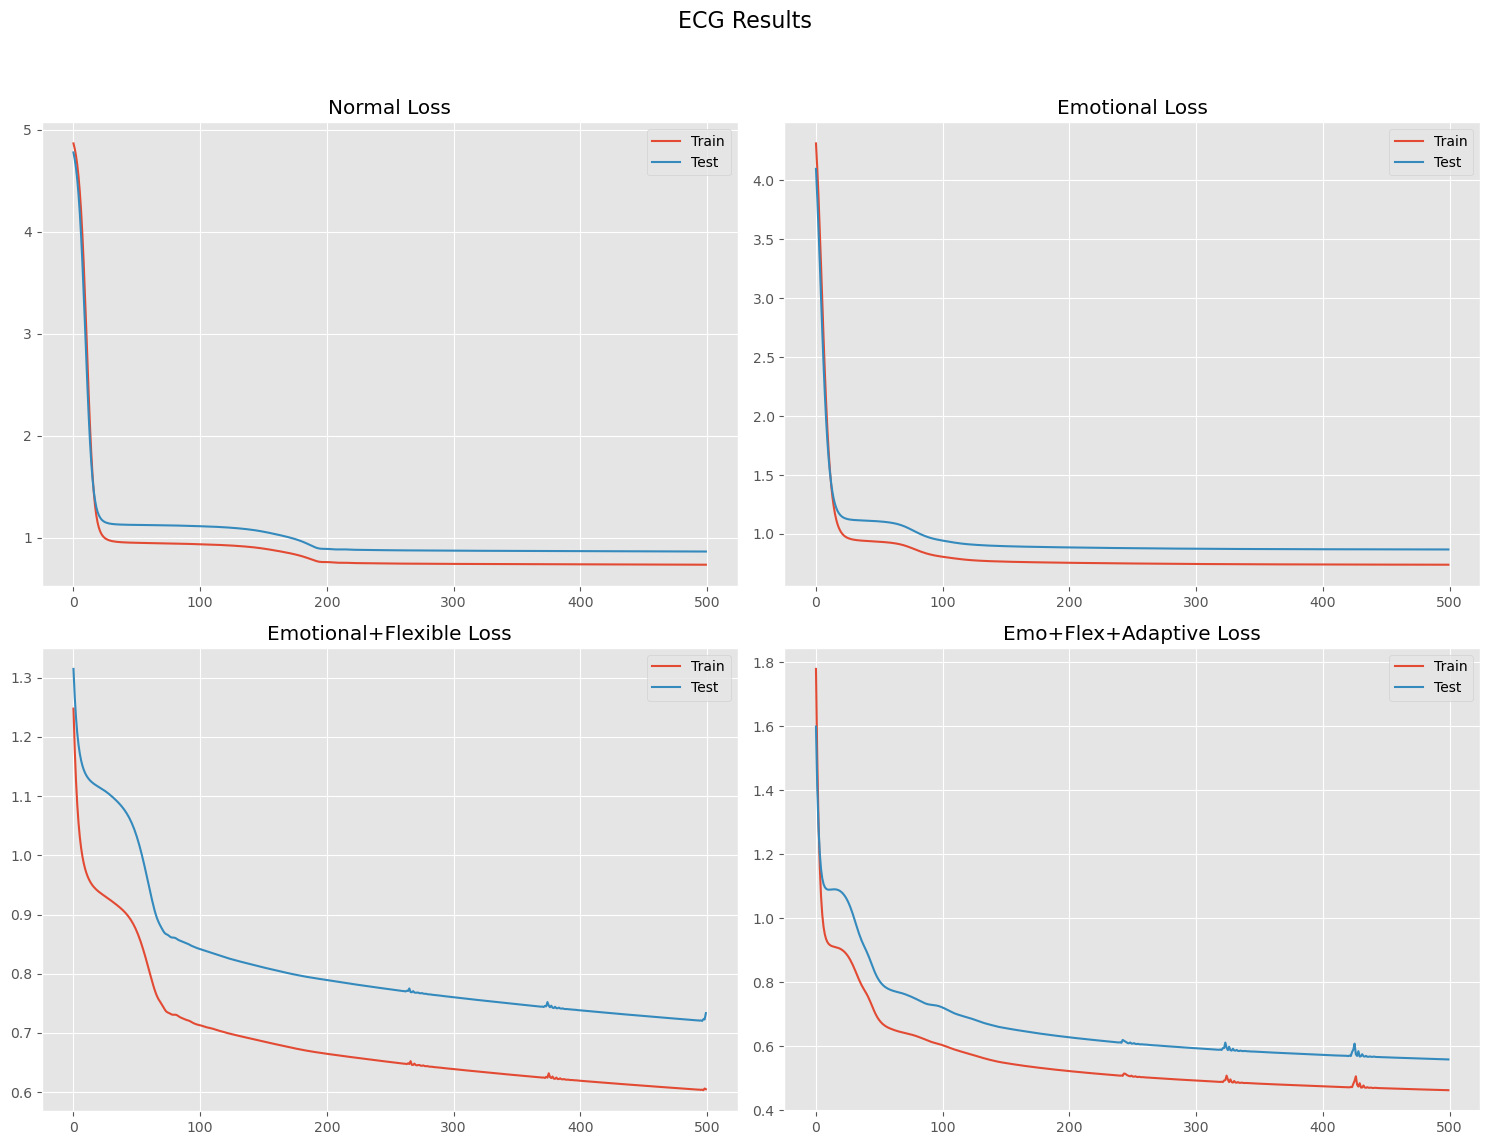


#################### Lorenz (regression) ####################

--- Normal ---
Ep   0 | Train: 2.5505 | Test: 1.8399
Ep  50 | Train: 0.9571 | Test: 0.9925
Ep 100 | Train: 0.6071 | Test: 0.5366
Ep 150 | Train: 0.5535 | Test: 0.4823
Ep 200 | Train: 0.5222 | Test: 0.4486
Ep 250 | Train: 0.5116 | Test: 0.4397
Ep 300 | Train: 0.5075 | Test: 0.4360
Ep 350 | Train: 0.5049 | Test: 0.4337
Ep 400 | Train: 0.5030 | Test: 0.4321
Ep 450 | Train: 0.5017 | Test: 0.4309

--- Emotional ---
Ep   0 | Train: 1.7535 | Test: 1.2799
Ep  50 | Train: 0.5825 | Test: 0.5076
Ep 100 | Train: 0.5365 | Test: 0.4649
Ep 150 | Train: 0.5117 | Test: 0.4402
Ep 200 | Train: 0.5050 | Test: 0.4344
Ep 250 | Train: 0.5026 | Test: 0.4322
Ep 300 | Train: 0.5011 | Test: 0.4310
Ep 350 | Train: 0.5001 | Test: 0.4301
Ep 400 | Train: 0.4993 | Test: 0.4295
Ep 450 | Train: 0.4987 | Test: 0.4290

--- Emotional+Flexible ---
Ep   0 | Train: 1.9790 | Test: 1.4055
Ep  50 | Train: 0.6093 | Test: 0.5463
Ep 100 | Train: 0.4775 | Test: 0.4234


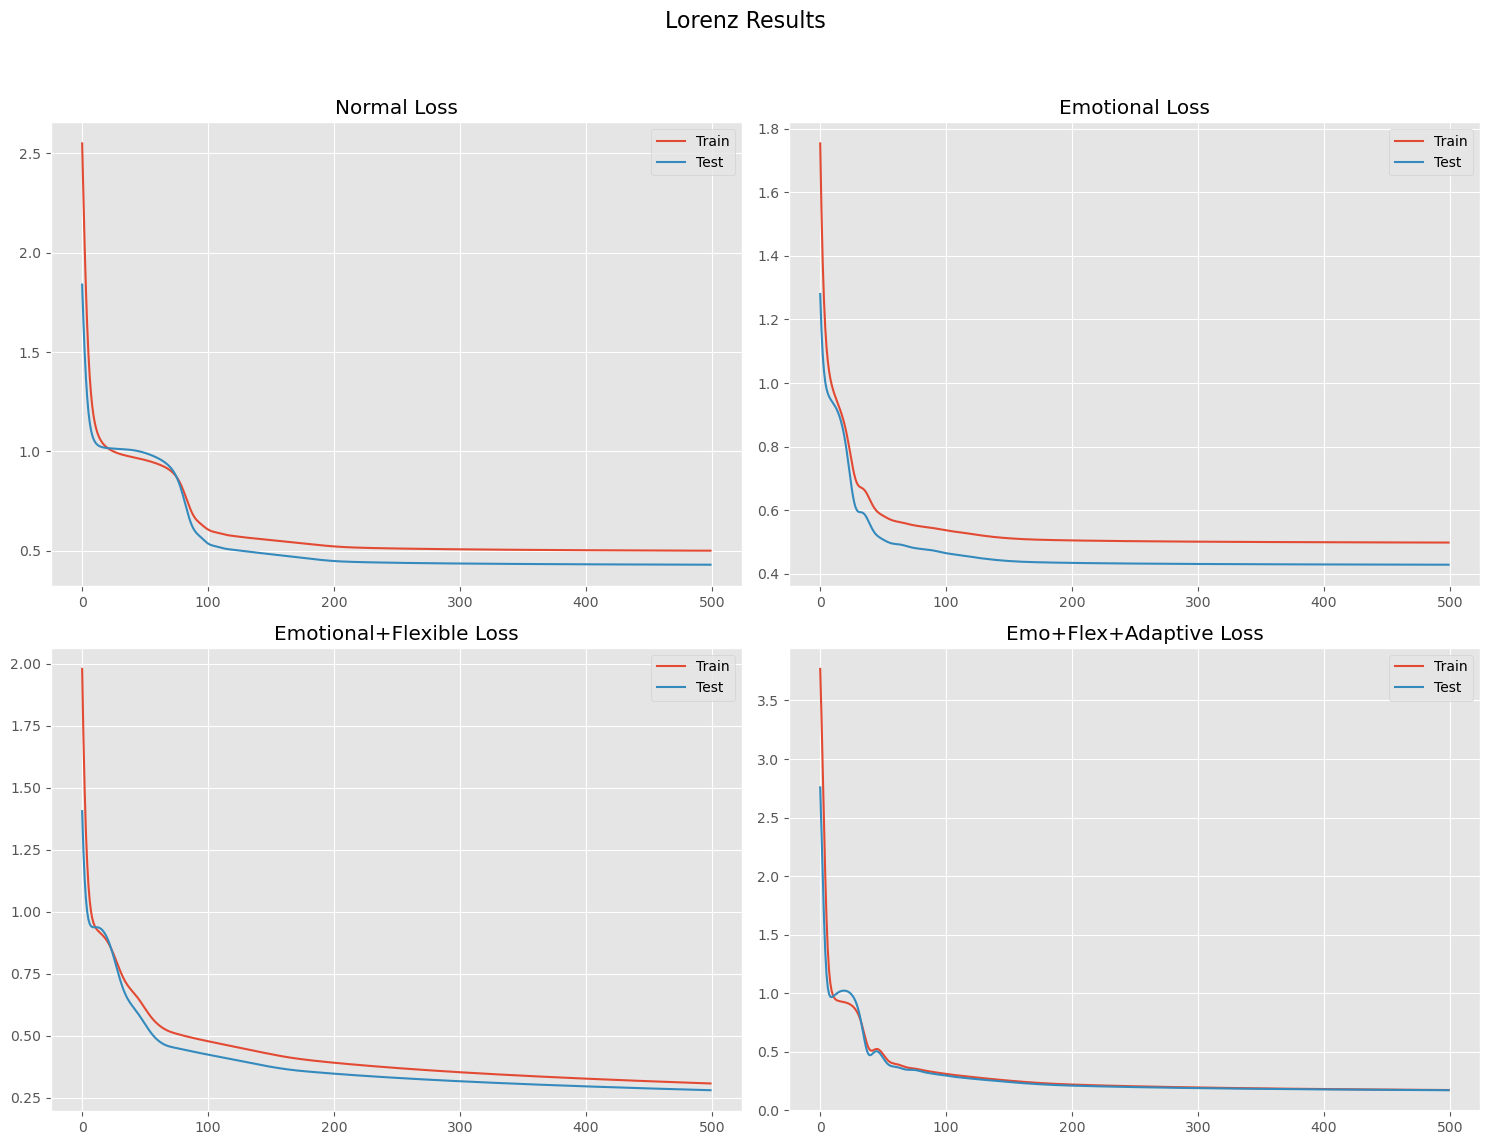


#################### Wine (classification) ####################

--- Normal ---
Ep   0 | Train: 0.8873 | Test: 0.8123
Ep  50 | Train: 0.1004 | Test: 0.0992
Ep 100 | Train: 0.0195 | Test: 0.0240
Ep 150 | Train: 0.0116 | Test: 0.0188
Ep 200 | Train: 0.0104 | Test: 0.0183
Ep 250 | Train: 0.0099 | Test: 0.0181
Ep 300 | Train: 0.0096 | Test: 0.0180
Ep 350 | Train: 0.0094 | Test: 0.0179
Ep 400 | Train: 0.0093 | Test: 0.0178
Ep 450 | Train: 0.0091 | Test: 0.0177
Final Acc: 98.15%

--- Emotional ---
Ep   0 | Train: 1.4987 | Test: 1.3924
Ep  50 | Train: 0.0506 | Test: 0.0576
Ep 100 | Train: 0.0162 | Test: 0.0246
Ep 150 | Train: 0.0124 | Test: 0.0208
Ep 200 | Train: 0.0113 | Test: 0.0197
Ep 250 | Train: 0.0107 | Test: 0.0192
Ep 300 | Train: 0.0104 | Test: 0.0188
Ep 350 | Train: 0.0101 | Test: 0.0186
Ep 400 | Train: 0.0099 | Test: 0.0184
Ep 450 | Train: 0.0098 | Test: 0.0183
Final Acc: 98.15%

--- Emotional+Flexible ---
Ep   0 | Train: 0.6066 | Test: 0.5192
Ep  50 | Train: 0.0730 | Test: 0.0781


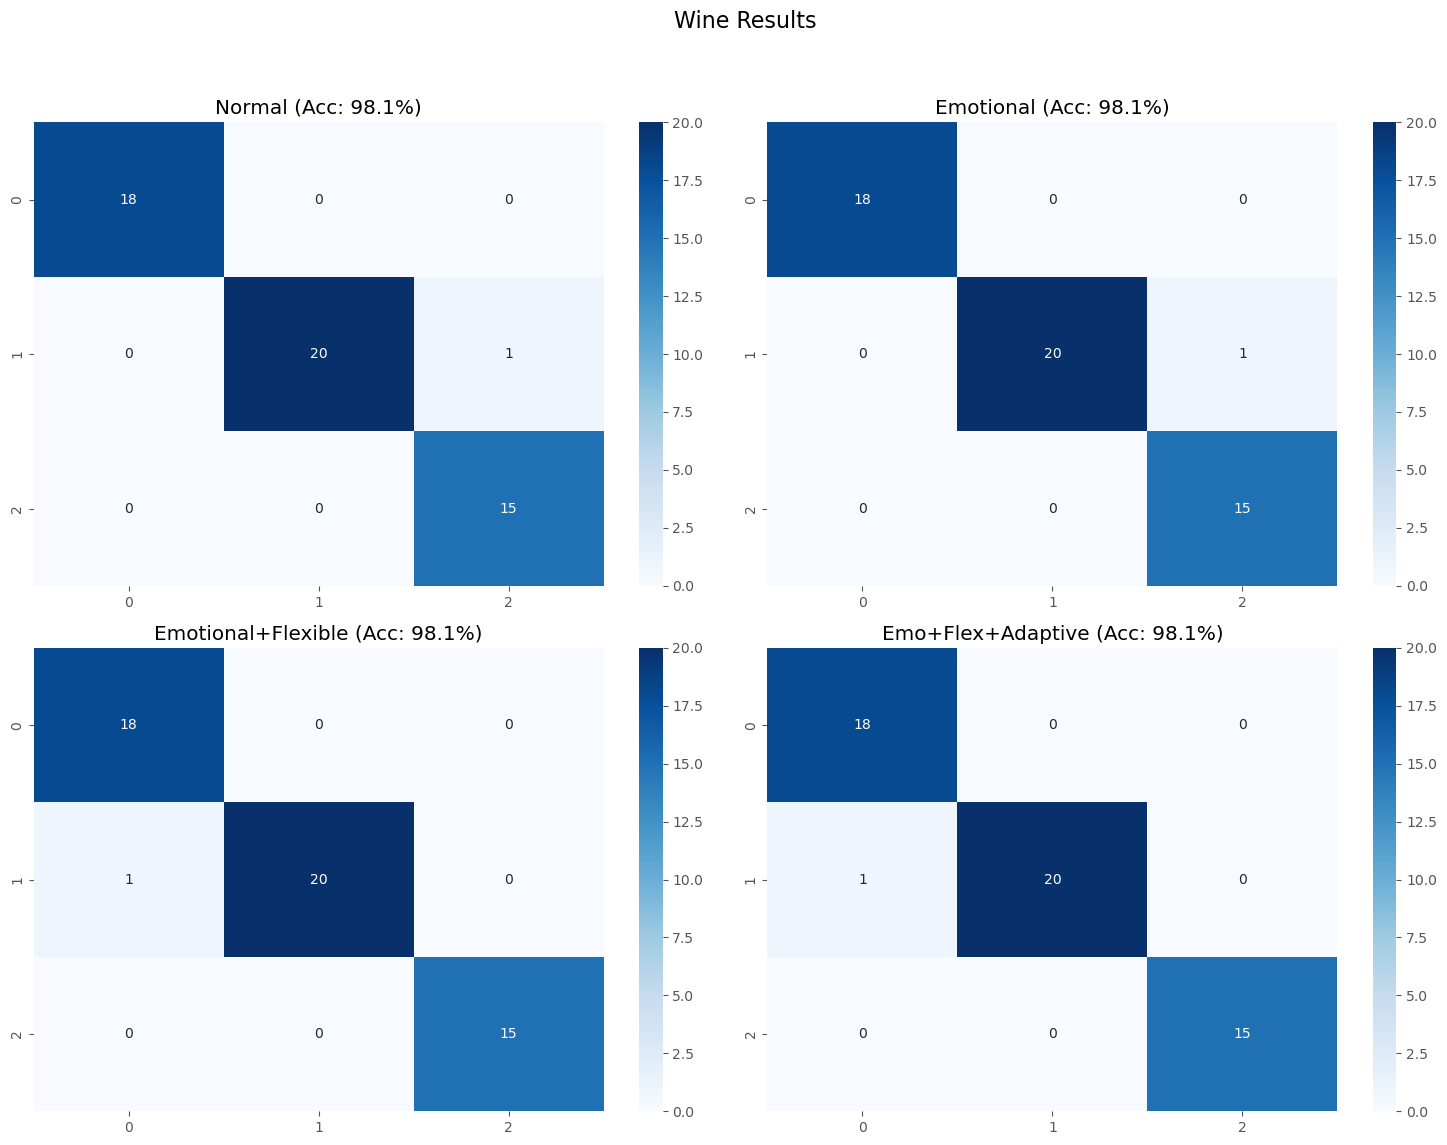


#################### Iris (classification) ####################

--- Normal ---
Ep   0 | Train: 0.3287 | Test: 0.2748
Ep  50 | Train: 0.0855 | Test: 0.0879
Ep 100 | Train: 0.0550 | Test: 0.0584
Ep 150 | Train: 0.0524 | Test: 0.0563
Ep 200 | Train: 0.0433 | Test: 0.0485
Ep 250 | Train: 0.0173 | Test: 0.0255
Ep 300 | Train: 0.0149 | Test: 0.0232
Ep 350 | Train: 0.0137 | Test: 0.0219
Ep 400 | Train: 0.0130 | Test: 0.0213
Ep 450 | Train: 0.0128 | Test: 0.0210
Final Acc: 93.33%

--- Emotional ---
Ep   0 | Train: 2.4684 | Test: 2.3401
Ep  50 | Train: 0.1154 | Test: 0.1169
Ep 100 | Train: 0.0805 | Test: 0.0838
Ep 150 | Train: 0.0704 | Test: 0.0732
Ep 200 | Train: 0.0645 | Test: 0.0672
Ep 250 | Train: 0.0606 | Test: 0.0634
Ep 300 | Train: 0.0573 | Test: 0.0604
Ep 350 | Train: 0.0537 | Test: 0.0572
Ep 400 | Train: 0.0486 | Test: 0.0528
Ep 450 | Train: 0.0403 | Test: 0.0458
Final Acc: 93.33%

--- Emotional+Flexible ---
Ep   0 | Train: 0.3662 | Test: 0.2841
Ep  50 | Train: 0.0854 | Test: 0.0889


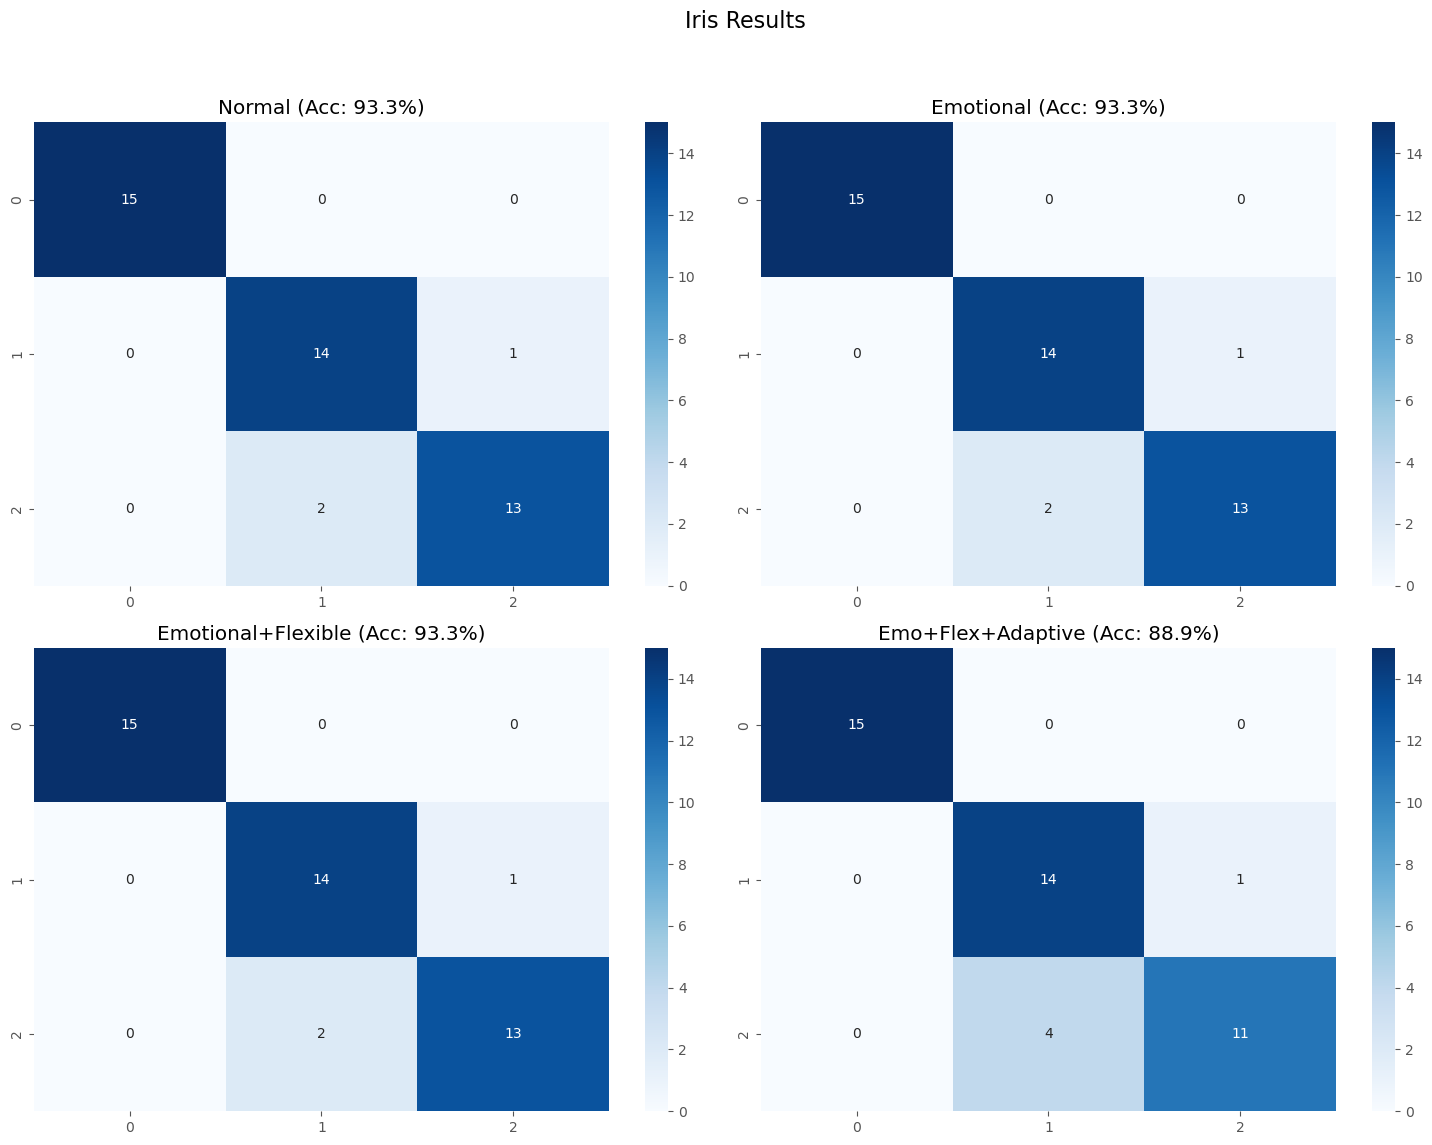

In [5]:
scenarios = {
    'A': 'Normal',
    'B': 'Emotional',
    'C': 'Emotional+Flexible',
    'D': 'Emo+Flex+Adaptive'
}

for ds in ['ECG', 'Lorenz']:
    run_experiment(ds, 'regression', scenarios)

for ds in ['Wine', 'Iris']:
    run_experiment(ds, 'classification', scenarios)